
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Found 7774 files belonging to 2 classes.
✅ Classes Found: ['benign', 'malignant']
📊 Class Weights: {0: 1.0, 1: 1.0}


Epoch 1/15


388/388 [==============================] - 499s 1s/step - loss: 0.3883 - accuracy: 0.8274 - val_loss: 0.3181 - val_accuracy: 0.8597
Epoch 2/15
388/388 [==============================] - 490s 1s/step - loss: 0.3333 - accuracy: 0.8530 - val_loss: 0.2673 - val_accuracy: 0.8878
Epoch 3/15
388/388 [==============================] - 498s 1s/step - loss: 0.3109 - accuracy: 0.8666 - val_loss: 0.2793 - val_accuracy: 0.8846
Epoch 4/15
388/388 [==============================] - 490s 1s/step - loss: 0.2877 - accuracy: 0.8769 - val_

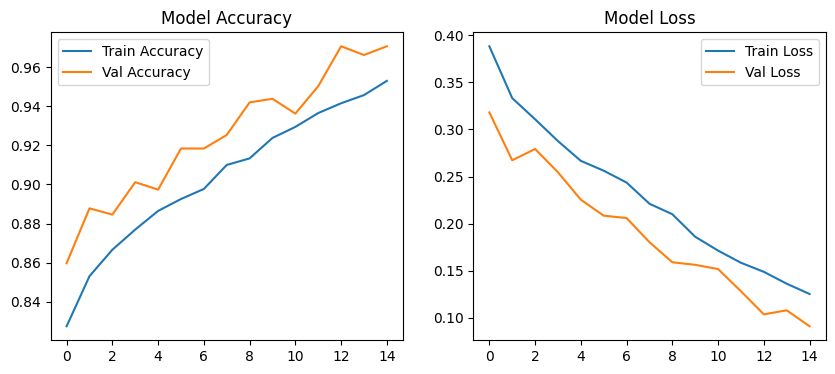

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os

# Enable mixed precision for performance
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# ===============================
# 1️⃣ Load Dataset from Directory
# ===============================
train_dir = "organized_gastric"
batch_size = 16
img_size = (224, 224)

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

class_names = dataset.class_names
print(f"✅ Classes Found: {class_names}")

# ===============================
# 2️⃣ Normalize & Split Dataset
# ===============================
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.map(lambda x, y: (x / 255.0, y)).cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)

# Split into train and validation
total_batches = len(dataset)
train_size = int(0.8 * total_batches)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

# ===============================
# 3️⃣ Compute Class Weights
# ===============================
# Extract all labels
all_labels = []
for _, labels in dataset.unbatch():
    all_labels.append(int(labels.numpy()))
all_labels = np.array(all_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights))
print(f"📊 Class Weights: {class_weights}")

# ===============================
# 4️⃣ Load Base Model
# ===============================
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# ===============================
# 5️⃣ Build Model
# ===============================
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

# ===============================
# 6️⃣ Compile Model
# ===============================
tf.config.optimizer.set_jit(True)  # Enable XLA
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# ===============================
# 7️⃣ Add Early Stopping
# ===============================
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ===============================
# 8️⃣ Train Model with Class Weights
# ===============================
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)

# ===============================
# 9️⃣ Save Model in Keras Format
# ===============================
model.save("resnet50v2_gastric_model.keras")
print("💾 Model saved as resnet50v2_gastric_model.keras")

# ===============================
# 🔟 Plot Accuracy & Loss
# ===============================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Model Loss")
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_18068\3935477709.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred.append(int(pred[0] > 0.5))  # sigmoid threshold at 0.5


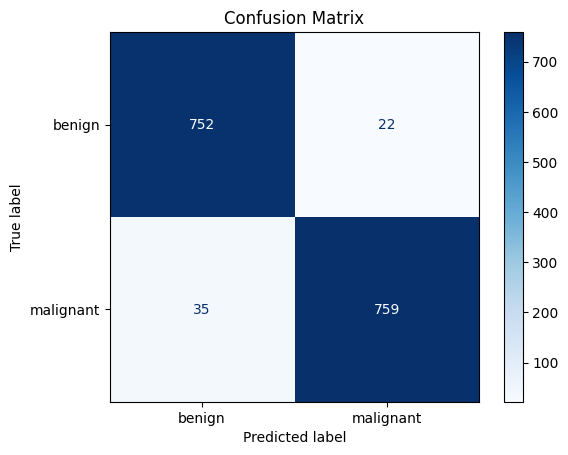

📈 Sensitivity (Recall for Malignant): 0.9559
📉 Specificity (True Negative Rate for Benign): 0.9716

🔎 Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.97      0.96       774
   malignant       0.97      0.96      0.96       794

    accuracy                           0.96      1568
   macro avg       0.96      0.96      0.96      1568
weighted avg       0.96      0.96      0.96      1568



In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# ===============================
# 🔍 Evaluate on Validation Set
# ===============================

# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds.unbatch():
    y_true.append(int(labels.numpy()))
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_pred.append(int(pred[0] > 0.5))  # sigmoid threshold at 0.5

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ===============================
# 📊 Confusion Matrix
# ===============================
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ===============================
# 📈 Sensitivity & Specificity
# ===============================
# cm = [[TN, FP], [FN, TP]]
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"📈 Sensitivity (Recall for Malignant): {sensitivity:.4f}")
print(f"📉 Specificity (True Negative Rate for Benign): {specificity:.4f}")

# Optional: Full classification report
print("\n🔎 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted probabilities
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    probs = model.predict(images).ravel()
    y_pred.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)
print(f"🔍 ROC AUC Score: {auc_score:.4f}")

1/1 [==============================] - 1s 862ms/step
🔍 ROC AUC Score: 0.9973



🖼 Predicting: SECTION A.png
1/1 [==============================] - 1s 666ms/step


C:\Users\PC\AppData\Local\Temp\ipykernel_21396\58187964.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_names[int(predictions[0] > 0.5)]


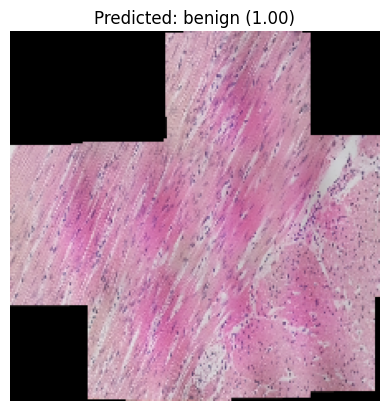


🖼 Predicting: SECTION B.png
1/1 [==============================] - 0s 149ms/step


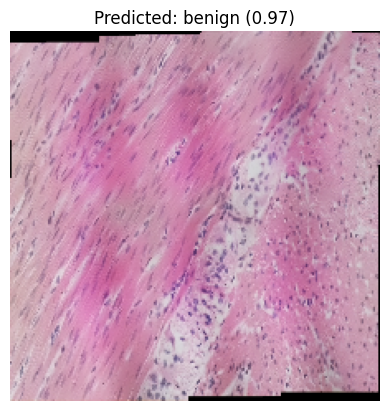


🖼 Predicting: SECTION C.png
1/1 [==============================] - 0s 133ms/step


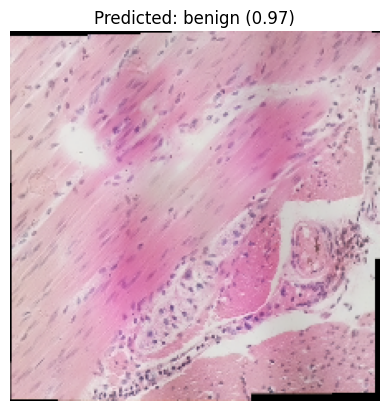


🖼 Predicting: SECTION D.png
1/1 [==============================] - 0s 151ms/step


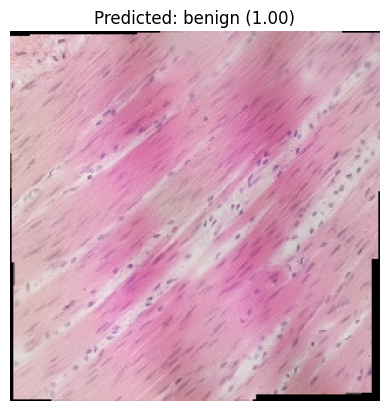


🖼 Predicting: SECTION E.png
1/1 [==============================] - 0s 133ms/step


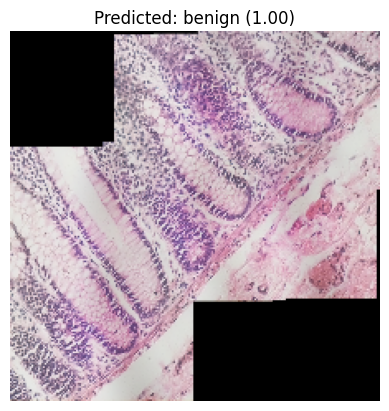


🖼 Predicting: SECTION F.png
1/1 [==============================] - 0s 132ms/step


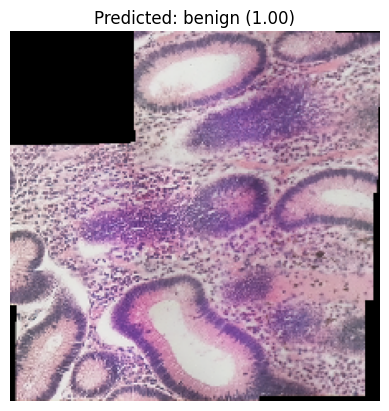


🖼 Predicting: SECTION G.png
1/1 [==============================] - 0s 133ms/step


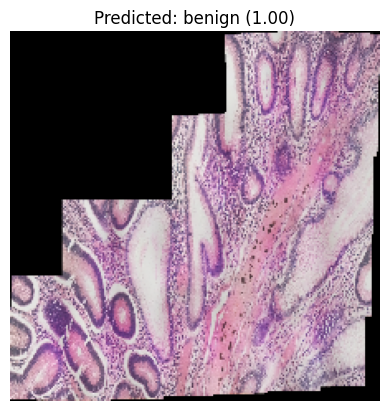


🖼 Predicting: SECTION H.png
1/1 [==============================] - 0s 147ms/step


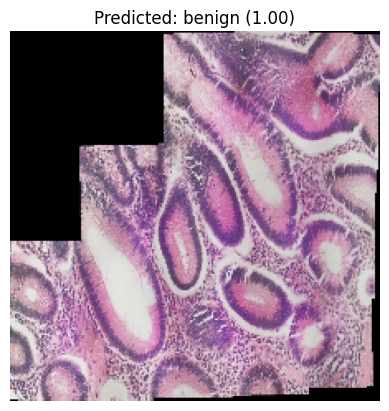

In [8]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load your trained model
model = tf.keras.models.load_model('resnet50v2_gastric_model.keras')

# Define class labels
class_names = ['benign', 'malignant']

# Path to new images
image_dir = r"D:\cancer. images\test.historical_images\cancer\C317980"

# Function to preprocess and predict a single image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Make batch of 1
    img_array = img_array / 255.0  # Normalize like in training

    predictions = model.predict(img_array)
    predicted_class = class_names[int(predictions[0] > 0.5)]

    confidence = predictions[0][0] if predicted_class == 'malignant' else 1 - predictions[0][0]

    # Show the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
    plt.show()

    return predicted_class, confidence

# Predict all images in the folder
for fname in os.listdir(image_dir):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"\n🖼 Predicting: {fname}")
        predict_image(os.path.join(image_dir, fname))
